In [1]:
#!pip install shap pandas==0.24.2 numpy==1.19.5 lightgbm==2.2.2 scikit-learn==0.22.1

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500000)
pd.set_option('display.max_rows', 500000)

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from datetime import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import lightgbm as lgb
import os
from datetime import datetime
from itertools import combinations, permutations
import random

from queue import Queue
import re
import gc

import json
import joblib

from tqdm import tqdm

LOCAL = not 'CLOUDSDK_CONFIG' in os.environ

if not LOCAL:
  
  from google.colab import files, drive, output
  drive.mount('/content/gdrive')

print('NumPy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Joblib version:', joblib.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('LightGBM version:', lgb.__version__)

NumPy version: 1.19.0
Pandas version: 0.24.2
Joblib version: 1.3.2
Scikit-Learn version: 1.0.2
LightGBM version: 2.2.2


In [3]:
RANDOM_SEED = 52
load_raw = False

In [4]:
from util import *
from compute_features import *

In [5]:
files = ['currentmodel1.csv', 'currentmodel2(YI).csv', 'currentmodel3.csv', 
 'currentmodel4(BT).csv', 'currentmodel5(composite).csv', 'currentmodel6(composite).csv', 
 'currentmodel7(composite).csv', 'currentmodel8(speed).csv', 'currentmodel9(FPMarLen).csv','currentmodel10.csv',
 'currentmodel_trueskill.csv', 'FP_count.csv', #'hko_weather.csv', 
         'horseDistance.csv', 
 'horse_graph_features(same dist).csv', 'jockeyhorse_graph_features.csv', 'jockeytrainer_graph_features.csv', 
 'jockey_graph_features.csv', 'num_race.csv', 'pos.csv','speed_diff.csv', 'trainerJockey_count.csv', 
 'trainer_graph_features.csv', 'TrueSkill.csv','currentmodel(Dividend).csv','new_data.csv']

folder = 'data'



if not load_raw:


  df = load_data('data(2019-2021)', files)
  df.reset_index(inplace=True, drop=True)
  df_2 = pd.read_csv('data(2019-2021)/zhangs_metric0p5.csv')
  df = pd.merge(df, df_2[['Season-#','Horse No.','zhangs_metric','jr_zhangs_metric']],  how='left', left_on=['Season-#','Horse No.'], right_on = ['Season-#','Horse No.'])

  df.reset_index(inplace=True, drop=True)



currentmodel1.csv (30430, 46)
currentmodel2(YI).csv (30430, 22)
currentmodel3.csv (30430, 8)
currentmodel4(BT).csv (30430, 23)
currentmodel5(composite).csv (30430, 14)
currentmodel6(composite).csv (30430, 10)
currentmodel7(composite).csv (30430, 11)
currentmodel8(speed).csv (30430, 21)
currentmodel9(FPMarLen).csv (30430, 10)
currentmodel10.csv (30430, 11)
currentmodel_trueskill.csv (30430, 14)
FP_count.csv (30430, 14)
horseDistance.csv (30430, 6)
horse_graph_features(same dist).csv (30430, 4)
jockeyhorse_graph_features.csv (30430, 2)
jockeytrainer_graph_features.csv (30430, 8)
jockey_graph_features.csv (30430, 8)
num_race.csv (30430, 3)
pos.csv (30430, 14)
speed_diff.csv (30430, 8)
trainerJockey_count.csv (30430, 10)
trainer_graph_features.csv (30430, 8)
TrueSkill.csv (30430, 31)
currentmodel(Dividend).csv (30430, 24)
new_data.csv (30430, 16)


In [7]:
df.loc[df['Positions1'].notnull(),'pos'] = df.loc[df['Positions1'].notnull(),'Positions1'].str.split()#.apply(len)
df.loc[df['Positions1'].notnull(),'len'] = df.loc[df['Positions1'].notnull(),'pos'].apply(len)
df.loc[df['Positions1'].notnull(),'pos'] = df.loc[df['Positions1'].notnull(),'pos'].apply(lambda x: [np.nan]*(5-len(x)) + x)

df[['pos_'+str(x) for x in range(5)]] = df['pos'].apply(pd.Series).rename(columns = lambda x : 'pos_' + str(x)).astype(np.float32)
for i in range(5):
    df['pos_'+str(i)+'_n'] = df['pos_'+str(i)]/df['Horses1']

df['year'] = df['Season-#'].apply(lambda x: int(x.split('-')[0]))
df['isWin'] = ( df['FP']==1 ).astype(np.float32)
    
# Assume weather conditions
df['Total Rainfall'] = 0.0
df['Prevailing Wind Direction'] = 0.0
df['Mean Wind Speed'] = 0.0
df['Cloud'] = np.nan

In [8]:
df['Blinker'] = df['Blinker'].astype(str).apply(lambda x: x.split(',')).apply(lambda x: ','.join(list(map(str.strip, x))))#.tolist()
df['zhangs_metric'] = np.log(df['zhangs_metric'])
df['jr_zhangs_metric'] = np.log(df['jr_zhangs_metric'])

df['Blinker'].tail()

c:\Users\johne\anaconda3\envs\horse\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
c:\Users\johne\anaconda3\envs\horse\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
c:\Users\johne\anaconda3\envs\horse\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\johne\anaconda3\envs\horse\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


30425                                       Tongue Tie
30426                               Sheep Cheek Pieces
30427                                       Tongue Tie
30428    Blinkers removed,Sheep Cheek rep'd,Tongue Tie
30429                                              nan
Name: Blinker, dtype: object

In [ ]:

df['Origin'] = df['Origin'].astype(str).apply(get_origin)
df = encodeCatagoricalFeatures(df, dump=False, load=True)

In [ ]:
df = preprocess_features(df)
df, blinker_features = compute_blinker_features(df, dump=False, load=True)
df = compute_weather_features(df)
df, rank_features = compute_rank_features(df)
df, compare_features = compute_compare_features(df)
df, graph_features = compute_graph_features(df)
df = compute_features(df)


In [24]:
old_fname = list(features)
features = list(map( lambda x: x.replace(' ','_'), features))
df = df.rename(columns=dict(zip(old_fname, features)))

odd_features = list(features)

In [ ]:
from hashlib import sha256

models = []

model_path = './'

lgb_model = lgb.Booster(model_file=os.path.join(model_path,'win_model2015.txt'))
models.append(lgb_model)

lgb_odd_model = lgb.Booster(model_file=os.path.join(model_path,'odd_model2015.txt'))



In [33]:
lgb_horseModels = HorseModels(lgb_model, lgb_odd_model)

capital = 3e4
money = []
numhit = []
hit_money = []
race_ids = []



for race_id, race_group in df.query('year>=2015').groupby('Season-#',sort=False):

  div = get_win_div(race_id)

  if not np.isnan(div) and div > 0:

    x_test = race_group.reset_index(drop=True)#.values



    y_true = race_group.FP.values

    win = race_group[race_group['FP']==1]['Horse No.'].values.astype(np.int32)
    if len(win)!=1:
      continue


    win = win[0]

    y_pred = lgb_horseModels.make_prediction(x_test, shift = 40)
    odd = lgb_horseModels.odd_predict(x_test, num_iteration = 95)

    # Filter out horses with high odds
    y_pred[(race_group['5min odd'].values > 70)] -= 3.5

    p = softmax(y_pred)

  
    
    horse_no = race_group.loc[: ,'Horse No.'].values.astype(np.int32)
    jockey_mu = race_group.loc[: ,'jockey_mu(1)'].values.astype(np.float32)
    horsetotal =  race_group.loc[: ,'HorseTotal'].values.astype(np.float32)
    fo = race_group.loc[: ,'Final Odds'].values

    bet_on, numbets = bet_by_model(p, odd, fo, horse_no, jockey_mu, horsetotal, thr = 1.1)

    # Conditions which we don't bet
    if len(bet_on) > 4 or len(bet_on) == 0 or race_group['Going_raw'].values[0]=='Wet Slow' or race_group['Going_raw'].values[0]=='Yielding':
      continue

    ishit = [bet == win for bet in bet_on]

    #amt = capital*(0.01)
    max_numbet = 10000

    numbets = [np.minimum(max_numbet, numbet) for numbet in numbets]

    debit = np.sum(numbets)*10

    capital -= debit

    # Scale down the dividend considering the pool size limit
    poolsize = race_group['Win Ticket'].sum()*1000.0
    original_div, div = get_win_div2(race_id, 1, debit, poolsize)
  
  
    numhit.extend(ishit)
      #Win
    if True in ishit:
      hit_money.append(div)
      
      gain = numbets[ishit.index(True)]*div
      capital += gain
      print('Date:',str(x_test.loc[0,'Date']))#.date()))

      print('Race id:',race_id)

      print('True rank:', y_true)
      print('Win:', win)
      print('Bet on:', bet_on)
      print('ishit:',ishit)
      print('numbet:',numbets)
      print('Debit:', debit)
      print('Dividend:', div)
      print('Money gain: {0:,.2f}'.format(gain))
      print('Capital: {0:,.2f}'.format(capital))
      print('---------------------------------------------\n')


    money.append(capital)
    race_ids.append(race_id)



Date: 2019-09-01 00:00:00
Race id: 2019-004
True rank: [12  3  1  9  5  4 13  7  6  2 10 11 14  8]
Win: 3
Bet on: [2, 3]
ishit: [False, True]
numbet: [1, 1]
Debit: 20
Dividend: 85.49928491650178
Money gain: 85.50
Capital: 30,055.50
---------------------------------------------

Date: 2019-09-08 00:00:00
Race id: 2019-014
True rank: [ 6  4  1  5  9  2  7 11 10  3  8 12]
Win: 3
Bet on: [3]
ishit: [True]
numbet: [1]
Debit: 10
Dividend: 33.999893879225226
Money gain: 34.00
Capital: 30,009.50
---------------------------------------------

Date: 2019-09-08 00:00:00
Race id: 2019-015
True rank: [ 3 11  8  6  2  7 10  1  4 12  5  9]
Win: 8
Bet on: [8, 1]
ishit: [True, False]
numbet: [1, 1]
Debit: 20
Dividend: 109.99875334995534
Money gain: 110.00
Capital: 30,099.50
---------------------------------------------

Date: 2019-09-08 00:00:00
Race id: 2019-016
True rank: [ 3  9 12 14  2 11  4 10  1  7  5 13  8  6]
Win: 9
Bet on: [9]
ishit: [True]
numbet: [1]
Debit: 10
Dividend: 51.99972424416234
Mon

In [34]:
money_df = pd.DataFrame(money,index=race_ids,columns=['money'])

[2.24198393] 0.7114210719641021


c:\Users\johne\anaconda3\envs\horse\lib\site-packages\pandas\plotting\_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


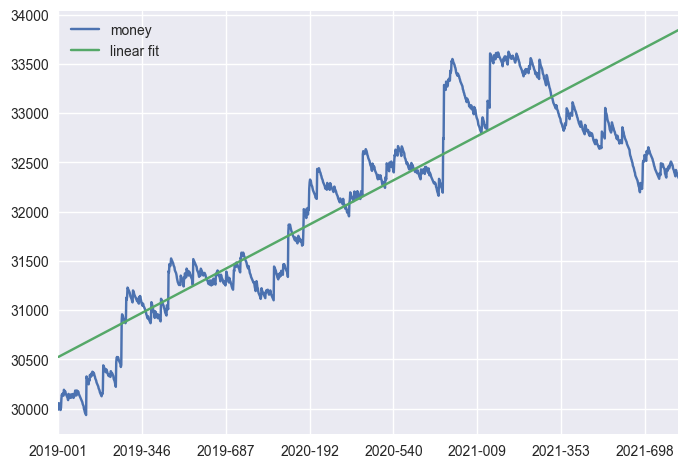

In [35]:
from sklearn.linear_model import *
from sklearn.metrics import r2_score

lin_reg = TheilSenRegressor(random_state=42).fit(X=np.arange(len(money_df)).reshape(-1,1), y=money_df['money'].values)
money_df['linear fit'] = lin_reg.predict(np.arange(len(money_df)).reshape(-1,1))
money_df.plot()
print(lin_reg .coef_, r2_score(money_df['linear fit'],money_df['money']))

In [41]:
from scipy import stats

r = np.mean(numhit)*np.mean(hit_money)/10
o = np.mean(hit_money)/10
n = len(numhit)
t = (np.sqrt(n)*(r-1))/(np.sqrt(r*(o-r)))
p_value = stats.t.sf(t, df=1)/2 

print('Max capital: {0:,.2f}'.format( np.max(money)))
print('Min capital: {0:,.2f}'.format( np.min(money)))
print('No. of hit:', np.sum(numhit))
print('Total no.:', n)
print('Win acc: %.2f%%' % (100*np.mean(numhit)))
print('Hit odd:', o)
print('Edge: %.3f' % r)
print('T-score: {0:,.2f}'.format(t))
print('P-value: {0:,.2f}%'.format(p_value*100))

print('Final capital: {0:,.2f}'.format( capital ) )
print('Max hit money:', np.max(hit_money))

money = np.array(money)

print(sha256(open('win_model2015.txt','rb').read()).hexdigest())
print(sha256(open('odd_model2015.txt','rb').read()).hexdigest())
print(datetime.now())

Max capital: 33,625.07
Min capital: 29,934.49
No. of hit: 266
Total no.: 2144
Win acc: 12.41%
Hit odd: 8.94135938366168
Edge: 1.109
T-score: 1.72
P-value: 8.39%
Final capital: 32,344.02
Max hit money: 584.4603453700765
220678ed8e787946c925f51d2fccc66adceca1f9d23b56446eba67d9c6b94062
26fe4989b0ae5c2834f36a64c9f4868f09500d08669c7b4d68905b520083c85d
2024-06-11 15:06:04.158728
